# Machine Learning Final Project 

## Topic : Pixel Recursive Super Resolution

* ECE-GY 6143 Machine Learning - Spring 2020
* Name and net ID : Kuan Wei Yu, kwy232

Click File > Save a Copy in Drive to make your own editable copy of this notebook. Then, in Colab, get the URL of your copy: click Share > Copy Link (make sure it is configured so that either "Anyone with the link can view" or "Anyone at NYU can view"). Paste that URL in the parentheses below, so that when you click the Open In Colab button it opens your copy of the notebook:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ozgMuQBTQZy5b3-7pbfnzoxwD3Jz_uz5?usp=sharing)

One-paragraph abstract. Explain what your topic is, and tell me what you are going to do.


# Overview

Super resolution problems aim to recover the resolution of images. Available solutions can repair and supplement detail patches to reconstruct high-resolution images. However, for missing features, in low-resolution images, which do not exist in original images, we need to use models to predict and generate them. Therefore, the best super-resolution model must consider the complex changes of objects, viewpoints, illuminations, and occlusion. It should also be able to draw sharp edges and determine the type of texture, shape and pattern in different parts of the image. That is, generate the realistic and plausible high-resolution images is quite touch.

This paper provide detailed de-blur method. It avoids using the traditional dictionary construction, a kind of straightforword method, instead extracts multiple layers of abstractions by learning layers of filter kernels. Combine two different nerual networks and thus achieve the realistic high-resolution image that can even fool a human observer up to 27.9%.


# Detailed discussion
**Work flow** of this team to approach pixel reursive super resolution
  - Pixel independent super resolution theory illustration.
  - Prove limitations o pixel independent theory by synthetic multimodal task experiments.
  - Pixel recursive super resolution theory illustration and experimental performance measurement.



## Probabilistic super resolution
The goal is trying to learn probabilistic super resolution model which can tell the correlation between a high resolution image and a low resolution image. We can express it as $p_\theta(y|x) $,
where x and y denote a low resolution image and a high resolution image respectively. Once we get the condition probability of pixel, we can reconstruct high resolutoin images. To maximize the parameters $\theta$ of the conditaional distribution $p$, we maximize a conditional log-likelihood objective as $$O(\bf \theta \rm | \mathcal D) = \sum_{(x,y^*) \in \mathcal D} \log p(\bf y^* \rm |x) \tag 1$$ where $y^*$ denotes gorund truth images.
The most important thing in this problem is consturcting a suitable pixel distribution. We can then get the realistic non-blurry images.

## Pixel independent super resolution
One of the simple form of the super resolution model is that assuming the ouput pixels, which is y, are conditioinally independent to the given inputs. That is, the conditional distribution $p(y|x)$ are the product of every independent pixel prediction. Suppose given a RGB image, which thus has 3 color channels with M pixels in each channel. Take the logarithm from each side, we have $$\log p(\bf y | x \rm) = \sum_{i = 1}^{3M} \log p(y_i \rm |x){\tag 2}$$
We can use **Gaussian** and **multinomial** to model the continuous and discrete pixel values respectively.
  - For the continuous output y:
  
  Using **Gaussian** distribtuion to reconstruct the equation (2) as $$\log p( y_{i} | x ) = -\frac{1}{2\sigma^{2}}||y_{i} - C_{\bf i\rm}(\bf x \rm)||_{2}^{2} - \log \sqrt{2\sigma^2 \pi}\tag 3$$
  where $y_i$ represents the nonlinear mapping output obtained through the convolutional neural network model, $C_{i}(x)$ denotes the estimated mean value of the $i^{th}$ element, and $\sigma^{2}$ is the variance. Generally speaking, the variance is known, which means that it is not learned, so the only thing need to be learned is the Euclidean norm (L2) between the mean values and the estimated values. Therefore, in this case, we can reduce the equation (1) to be minimizing the MSE between $y_{i}$ and $C_i(x)$ across the pixels and channels throughout the dataset. Finally, we can use CNN model to learn the Gaussian parameters to obtain the optimal mean values $C_{i}(x)$.
  - For the discrete ouput y:

  Use **multinomial** distribution model as the predictive model for each pixel. And the prediction probabilty can be described as 
  $$\log p(y_{i} = k | x) = w_{jk}^{T} C_{i}(x) - \log \sum_{v = 1}^{k} e^{w_{jv}^{T}C_{i}(x)} \tag 4$$
  Therefore, our goal is to get the optimal softmax weights from the prediction model, where $\{w_{jk}\}^{3,K}_{j=1, k=1}$ denotes the softmax weights of the K possible discrete pixel values in 3 channels.


  However, the independent model can not handle with the multi-modality condition. According to [[1]](https://arxiv.org/pdf/1702.00783.pdf), they created a synthetic dataset to demonstrate how independent model fail at condition image modeling. For the toy example created by MNIST, the digits randomly place in either left-top or right-bottom corner. The trainning results through a several layers convolutional neural network was a blend and blurry images where both corners appears digits. And the similar results happened when using a discrete, per-pixel cross-entropy to predict the images. Only **PixelCNN** can explicitly capture the location of digits and produce a clear images.


## Pixel Recursive Super Resolution

The reason that previous independent models fail to produce the explicity image is because they lack of the conditional probability between predicted pixels. One solution is to factorize the joint distribution using the chain rule, $$\log p(\bf y \rm |\bf x \rm ) = \sum_{i=1}^{M} \log \it p (\bf y_{\rm \it i} \rm |\bf x\rm ,\bf y_{\rm \it <i}) \rm \tag 5$$ And it is just like **PixelCNN** we discuss above, the $y_{i} $ are conditional dependent to the input and the previous outputs. One of the benefits is that the conditional dependences are flexible and easy to infer. In early auto-regression distribution model, they ignore the conditioning of the low resolution image. To solve this issue, the team modify the architecture of PixelCNN to add more dependencies on conditioning of low resolution image. They factorize the procedure into two parts, Prior network and Conditioning network.

- ### Prior network (PixelCNN):
Use PixelCNN to add realistic high-resolution details to 8x8 source image(in their experiment). This is also known as a autoregressive model, which captures the serial dependencies of the pixels.

- ### Conditioning network (CNN):
The conditionaing network part captures the global structure of the low resolution image. Map the 8×8 source image (in thier experiment)against other high resolution images. It downsizes other high-res images to 8×8 (source images size)and tries to make a match.

Let $A_{i}(x)$ denotes a conditioning network predicting a vector of logit values corresponding to the K possible values of the $i^{th}$ ouput pixel; $B_{i}(x)$ denotes a prior network predicting a vector of logit values for the $i^{th}$ output pixel. $$p(y_{i}|x,y_{i}) = softmax(A_{i}(x) + B_{i}(y_{< i})) \tag 6$$
  Through stochastic gradient ascent, maximizing the conditional
log likelihood in equation (1) to optimize the parameters of A and B. That is, optimize a cross-entropy loss between the model’s predictions in (6) and discrete ground truth labels $y^* \in \{1,...,K\}$,
$$O_{1} = \sum_{(x,y*) \in D} \sum_{i=1}^{M}\bigg (\mathbb{1}[\bf y_{\rm i}\rm^*]^T(A_{i}(x) + B_{i}(y^*_{<i})) - lse(A_{i}(x) + B_{i}(y_{<i}^*))\bigg) \tag 7$$
where lse is log-sum-exp operator corresponding to the log of the denominator of a softmax, and $\mathbb{1}[k]$ denotes a one-hot indicator vector with its $k^{th}$ dimension sets to 1. However, the trainning model usually ignore the conditioning network while using equation (7). As a result, we include a new loss to measure
the cross-entropy between the conditioning network’s predictions and ground truth labels as 
$$O_{2} = \sum_{(x,y*) \in D} \sum_{\it i=1}^{M}\bigg (\mathbb{1}[\bf y_{\rm \it i}\rm^*]^T(2A_{\it i}(x) + B_{\it i}(y^*_{<i})) - lse(A_{i}(x) + B_{i}(y_{<i}^*)) - lse(A_{\it i}(x))\bigg) \tag 8$$


## Implementation Details

The nerual networks are basically composed by Conditioning network and prior network. The former one is a feed-forward cnn that takes a low resolution image through a series of ResNet block and transposed convolution layers. The later one, prior network architecture, consists of 20 gated PixelCNN blocks.

## NOTE
Some details we mentioin above.

### PixelCNN 

See the Reference [2], [3].

Build a single CNN that takes as input an image and outputs a distribution for each (sub-)pixel. 

  - Mask Convolution:

    Due to the autoregressive feature, every output pixel i should not see any pixel $\geq$ i. And how could we implemented it? Use mask convolutions. There are two types of mask can be applied to this implementation. One is spatial mask, which can let the pixel $\geq i$ is hidden from the pixel $i$; the other one is the color RGB mask. Let every pixel needs to take into account the RGB values.
  - Discretized Logistic Mixture Likelihood

    The output of the network is a distribution. We can use mixture of logistics to improve it. 

### ResNet

Deep residual network. Reference [5]


- Deep network degradation:

  From previous experience, the depth of the network is critical to the performance of the model. When the number of network layers is increased, the network can extract more complex feature patterns, so, theoretically, when the model is deeper we can optain the better result. However, experiments have found that the deep network has a degradation problem : when the network depth increases, the network accuracy becomes saturated, or even decreases. We know that the deep network has the problem of gradient disappearance or explosion, which makes it difficult to train deep learning models. But now there are some skills such as BatchNorm to alleviate this problem. Therefore, the degradation problem of deep networks is very surprising.

Now, ResNet, a residual learning framework was presented to ease the training of networks that are substantially deeper than those used previously.

# Code Replication
In this part, I will reproduce the code from [Berkeley RLL
](https://github.com/rll).  

First, Go to **Runtime** -> **Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

## Download the smaple_data. 
We will use the `wget` command to retrieve zip files to our Google Colab storage area. And use `unzip` to decompress the files. (We can run `wget`, `unzip` and many other basic Linux commands in Colab by prefixing them with a `!` or `%`.)

In [1]:
!if [ -d cs294-158-autoreg-master ]; then rm -Rf cs294-158-autoreg-master; fi
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17npUPcK1eXV9YtMMODwQEIvLkUgq8m2m' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17npUPcK1eXV9YtMMODwQEIvLkUgq8m2m" -O cs294-158-autoreg-master.zip && rm -rf /tmp/cookies.txt
!unzip -qq cs294-158-autoreg-master.zip
!rm cs294-158-autoreg-master.zip
!pip install cs294-158-autoreg-master/

--2020-05-17 01:28:50--  https://docs.google.com/uc?export=download&confirm=&id=17npUPcK1eXV9YtMMODwQEIvLkUgq8m2m
Resolving docs.google.com (docs.google.com)... 173.194.79.102, 173.194.79.101, 173.194.79.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-8g-docs.googleusercontent.com/docs/securesc/b4v9q9q64n8ku3984mk4a8eunoe2a3us/kfaecnh09sb7m0js3a9cj5m3h23e5lii/1589678925000/06419056966375271799/12260638759263183363Z/17npUPcK1eXV9YtMMODwQEIvLkUgq8m2m?e=download [following]
--2020-05-17 01:28:51--  https://doc-0k-8g-docs.googleusercontent.com/docs/securesc/b4v9q9q64n8ku3984mk4a8eunoe2a3us/kfaecnh09sb7m0js3a9cj5m3h23e5lii/1589678925000/06419056966375271799/12260638759263183363Z/17npUPcK1eXV9YtMMODwQEIvLkUgq8m2m?e=download
Resolving doc-0k-8g-docs.googleusercontent.com (doc-0k-8g-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to

## Download the pretrained model

Again, use `wget` to download pretrained model.

In [2]:
!if [ -d pretrained_models ]; then rm -Rf pretrained_models; fi
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CuFbTWshUfmU3F4bc2SODxzMm1vFU4hC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CuFbTWshUfmU3F4bc2SODxzMm1vFU4hC" -O pretrained_models.zip && rm -rf /tmp/cookies.txt
!unzip -qq pretrained_models.zip
!rm pretrained_models.zip

--2020-05-17 01:29:14--  https://docs.google.com/uc?export=download&confirm=Y59f&id=1CuFbTWshUfmU3F4bc2SODxzMm1vFU4hC
Resolving docs.google.com (docs.google.com)... 74.125.143.138, 74.125.143.100, 74.125.143.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.143.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-74-docs.googleusercontent.com/docs/securesc/v637eqaqitrer3sdoh8cr0acti3442hq/ls573sfhl9rgqo60n2rg47b9hg5msqgu/1589678925000/06419056966375271799/11042064633695904801Z/1CuFbTWshUfmU3F4bc2SODxzMm1vFU4hC?e=download [following]
--2020-05-17 01:29:14--  https://doc-0g-74-docs.googleusercontent.com/docs/securesc/v637eqaqitrer3sdoh8cr0acti3442hq/ls573sfhl9rgqo60n2rg47b9hg5msqgu/1589678925000/06419056966375271799/11042064633695904801Z/1CuFbTWshUfmU3F4bc2SODxzMm1vFU4hC?e=download
Resolving doc-0g-74-docs.googleusercontent.com (doc-0g-74-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connectin

## Demo: A Simple Autoregressive Model on 2D Data

Before go into the PixelCNN Super Resolution, we should go first to a simple autoregressive model on 2D data. A autoregressive model is the most important part in PixelCNN. From the theory above, we have mentioned that the autoregressive model data, in every pixel i, could not see any pixel $\geq i$.

If you click on the small folder icon on the far left of the Colab interface, you can see the files in your Colab storage. We use `deepul_helper ` function under the **cs294-158-autoreg-master** directory, and `tqdm` is the library that can show the progress bar. 

In [0]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from deepul_helper.data import load_demo_2
from deepul_helper.utils import to_one_hot
from deepul_helper.visualize import plot_2d_dist, plot_train_curves

- Use `PIL`package to handle the image.
- Use `torch.device` command to assign the torch tensor into different devices. There are two different devices, `cuda` and `cpu`. The former one means that use GPU to run the code, the latter one is instead running by CPU. 
- Load the data and split into training set and test set.  
- First use the smile image from `wilson1yan's` github.

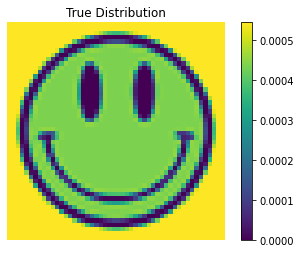

In [4]:
from PIL import Image
from urllib.request import urlopen
import io

device = torch.device('cuda') # Use GPU to run the code.
n_train, n_test, d = 20000, 5000, 50
loader_args = {'batch_size':128, 'shuffle':True}

fd = urlopen('https://wilson1yan.github.io/images/smiley.jpg')
#fd = urlopen('https://cdn4.iconfinder.com/data/icons/bear-emoji/512/Laugh-512.png')

image_file = io.BytesIO(fd.read())
im = Image.open(image_file).resize((d, d)).convert('L') # transform to gray scale
im = np.array(im).astype('float32') # convert to the pixel value from 0 to 255
dist = im / im.sum()

# plot the image with color bar
plt.figure()
plt.title('True Distribution')
plt.imshow(dist)
plt.axis('off')
plt.colorbar()
plt.show()

Create a function that given a image, randomly select the trainning set number of pixels in the dist (image convert to the pixel values).


In [0]:
def generate_2d_data(n, dist):
    import itertools
    d1, d2 = dist.shape
    pairs = list(itertools.product(range(d1), range(d2)))
    idxs = np.random.choice(len(pairs), size=n, replace=True, p=dist.reshape(-1))
    samples = [pairs[i] for i in idxs]

    return np.array(samples).astype('float32')

Convert the image data into integer. And make it as a training set.

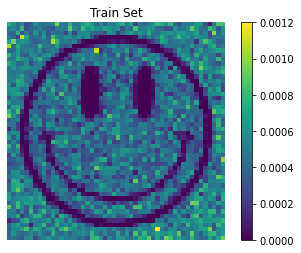

In [6]:
train_data, test_data = generate_2d_data(n_train, dist), generate_2d_data(n_test, dist)

idxs = train_data.astype('int32') # convert to Integer
train_dist = np.zeros((d, d))

for i in range(len(train_data)):
    train_dist[idxs[i][0], idxs[i][1]] += 1
train_dist /= train_dist.sum()

plt.figure()
plt.title('Train Set')
plt.imshow(train_dist)
plt.axis('off')
plt.xlabel('x1')
plt.ylabel('x0')
plt.colorbar()
plt.show()

In [0]:
class NumpyDataset(data.Dataset):
    def __init__(self, array, transform=None):
        super().__init__()
        self.array = array
        self.transform = transform

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        x = self.array[index]
        if self.transform:
            x = self.transform(x)
        return x

In [0]:
train_dset, test_dset = NumpyDataset(train_data), NumpyDataset(test_data)
train_loader, test_loader = data.DataLoader(train_dset, **loader_args), data.DataLoader(test_dset, **loader_args)

Build a class for the simple autoregression model. It inherits from the `nn module` from Pytorch. 

It has `nll` and `get_dist` two commdands. The former one is for the loss function, the later one is the probability distribution.

`nn.Sequential` is a sequential container to build a neural network. Modules will be added to it in the order they are passed in the constructor. In this case, we first use linear as first layer, then pass through ReLU, a activation function, then again a linear function, and so on. There are 5 layers in total.


In [0]:
class SimpleAutoregModel(nn.Module):
    # Model p(x0)p(x1|x0), p(x0) as a histogram, p(x1|x0) as an MLP
    def __init__(self):
        super().__init__()
        self.logits_x0 = nn.Parameter(torch.zeros(d), requires_grad=True)
        self.cond_x1 = nn.Sequential(
            nn.Linear(d, 50),
            nn.ReLU(), # ReLU is a activation function
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, d)
        )
    #loss function
    def nll(self, x):
        batch_size = x.shape[0]
        x0, x1 = x[:, 0], x[:, 1],

        # Loss for x0
        logits_x0 = self.logits_x0.unsqueeze(0).repeat(batch_size, 1)
        nll_x0 = F.cross_entropy(logits_x0, x0.long())

        # Loss for x1 | x0
        x0_onehot = to_one_hot(x0.long(), d, device) # use onehot as input
        logits_x1 = self.cond_x1(x0_onehot)
        nll_x1 = F.cross_entropy(logits_x1, x1.long())

        return nll_x0 + nll_x1

    def get_dist(self):
        with torch.no_grad():
            x0 = torch.arange(d).to(device)
            x0 = to_one_hot(x0, d, device)

            prob_x0 = F.softmax(self.logits_x0, dim=0).unsqueeze(1)
            prob_x1 = F.softmax(self.cond_x1(x0), dim=1)
            prob = prob_x0 * prob_x1
            return prob.cpu().numpy()

In [0]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return np.mean(train_losses[-50:])

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer)
        test_loss = eval_loss(model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if epoch in [0, 2, 19, 49]:
            plot_2d_dist(model.get_dist(), title=f'Epoch {epoch}, Learned Distribution')
        
    plot_2d_dist(model.get_dist())
    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')  

Train the model by the simle face we prepare from above and print the 0, 2, 19, and 49 epochs.

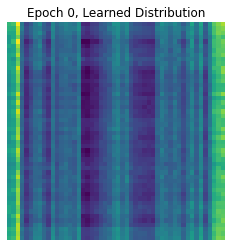

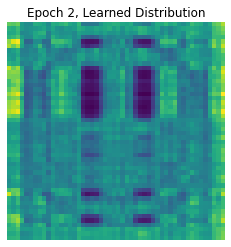

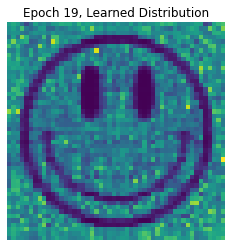

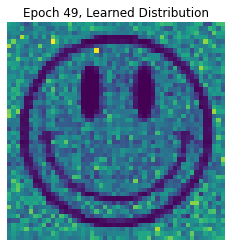

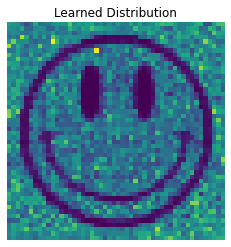

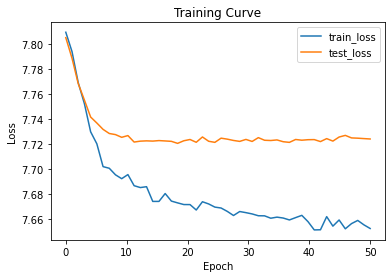

In [11]:
model = SimpleAutoregModel().to(device)
train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3)) 

Along with the training times increase, we can see the figure is more explicit.

### Entension

Now, let's try another image to see if it also works or not.

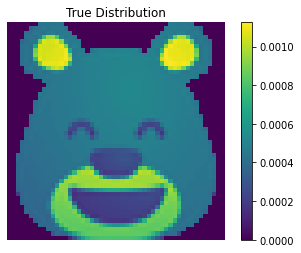

In [12]:
fd = urlopen('https://cdn4.iconfinder.com/data/icons/bear-emoji/512/Laugh-512.png')

image_file = io.BytesIO(fd.read())
im = Image.open(image_file).resize((d, d)).convert('L') # transform to gray scale
im = np.array(im).astype('float32') # convert to the pixel value from 0 to 255
dist = im / im.sum()

# plot the image with color bar
plt.figure()
plt.title('True Distribution')
plt.imshow(dist)
plt.axis('off')
plt.colorbar()
plt.show()

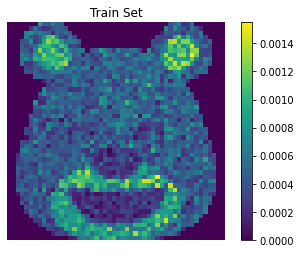

In [13]:
train_data, test_data = generate_2d_data(n_train, dist), generate_2d_data(n_test, dist)

idxs = train_data.astype('int32') # convert to Integer
train_dist = np.zeros((d, d))

for i in range(len(train_data)):
    train_dist[idxs[i][0], idxs[i][1]] += 1
train_dist /= train_dist.sum()

plt.figure()
plt.title('Train Set')
plt.imshow(train_dist)
plt.axis('off')
plt.xlabel('x1')
plt.ylabel('x0')
plt.colorbar()
plt.show()

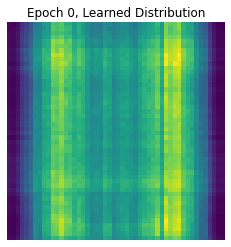

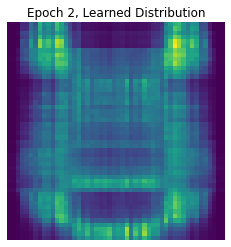

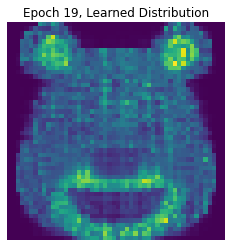

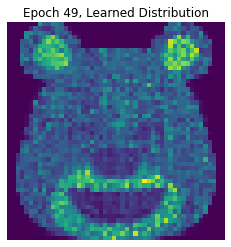

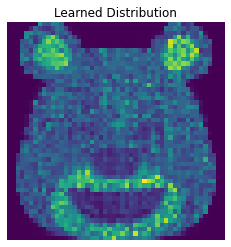

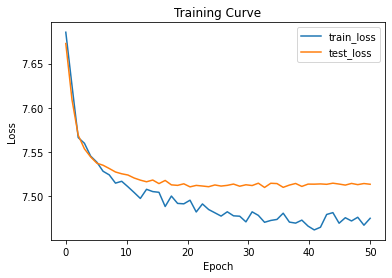

In [14]:
train_dset, test_dset = NumpyDataset(train_data), NumpyDataset(test_data)
train_loader, test_loader = data.DataLoader(train_dset, **loader_args), data.DataLoader(test_dset, **loader_args)

model = SimpleAutoregModel().to(device)
train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3)) 

## Demo: PixelCNN

Here is some demo using PixelCNN to train the MINST dataset.


In [0]:
import numpy as np
import torch
import torch.nn as nn
from os.path import join

from deepul_helper.models import PixelCNN
from deepul_helper.visualize import visualize_batch

As we discuss above, the first step of PixelCNN is using mask convolution.

`MaskConv2d` function is going to create mask

In [0]:
class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        return F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1

Let's go into the PixelCNN function created by `Berkeley RLL`.
The layer of Pixelcnn is :
  - Convolution 2D
  - ReLU activation function
  - In contrast to the lab in course, which will downsize the results, here we use upsample to generate the image, and thus will enlarge the result size.
  - Again Covolution in 2D, with padding equals to 1
  - ReLU activation function
  - Upsample
  - Covolution
  - ReLU

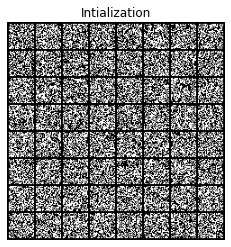

Epoch 0 Test Loss: 0.1274 bits/dim


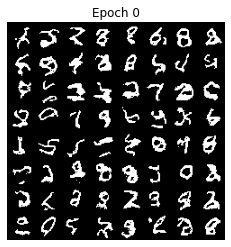

Epoch 1 Test Loss: 0.1201 bits/dim


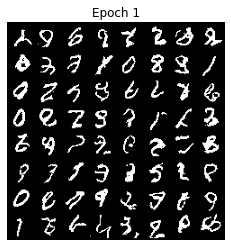

Epoch 2 Test Loss: 0.1177 bits/dim


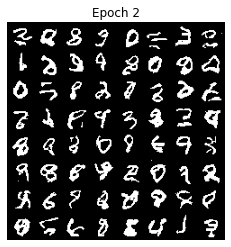

Epoch 8 Test Loss: 0.1134 bits/dim


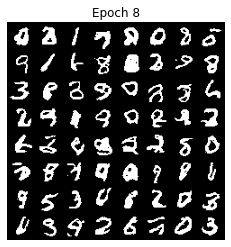

Epoch 19 Test Loss: 0.1087 bits/dim


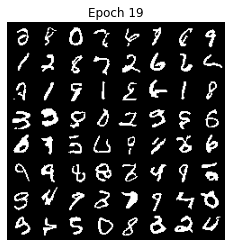

In [17]:
model = PixelCNN(device).to(device)
test_losses = np.load(join('pretrained_models', 'pixelcnn', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'pixelcnn', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization') # show the initialization image
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## Demo : Class-Conditional PixelCNN

Add condition one-hot label to the MINST class.

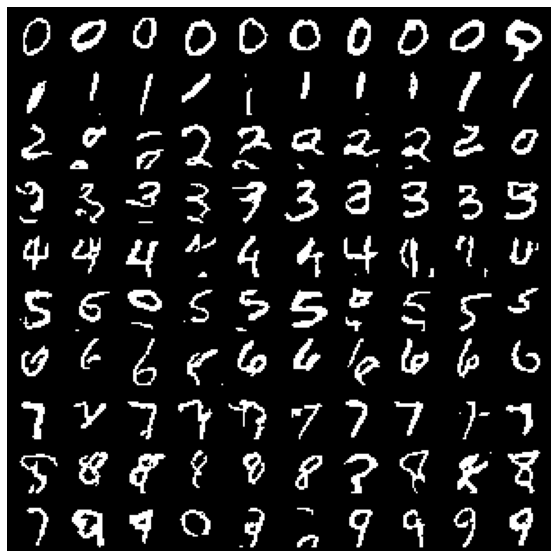

In [18]:
model = PixelCNN(device, conditional_size=(10,), n_layers=5).to(device)
model.load_state_dict(torch.load(join('pretrained_models', 'pixelcnn_class', 'checkpoints', 'epoch9_state_dict')))

cond = torch.arange(10).unsqueeze(1).repeat(1, 10).view(-1).to(device)
cond = to_one_hot(cond, 10, device)
samples = model.sample(100, cond=cond)
visualize_batch(samples, nrow=10, figsize=(10, 10))

Load data from MINST.

In [19]:
def load_data():
    from torchvision import transforms
    from torchvision.datasets import MNIST
    import torch.utils.data as data

    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: (x > 0.5).float()
    ])
    train_dset = MNIST('data', transform=transform, train=True, download=True)
    test_dset = MNIST('data', transform=transform, train=False, download=True)

    train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True,
                                   pin_memory=True, num_workers=2)
    test_loader = data.DataLoader(test_dset, batch_size=128, shuffle=True,
                                  pin_memory=True, num_workers=2)

    return train_loader, test_loader
load_data()
print('Pre-downloaded dataset')

import warnings
warnings.filterwarnings('ignore')

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
Pre-downloaded dataset


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Image Super-Resolution with a PixelCNN
We condition on subsampled-version of MNIST images. Note that we show the subsampled image in an enlarged form for easier viewing. In every two columns, left side is a low resolution image, and right side is the recovered one.

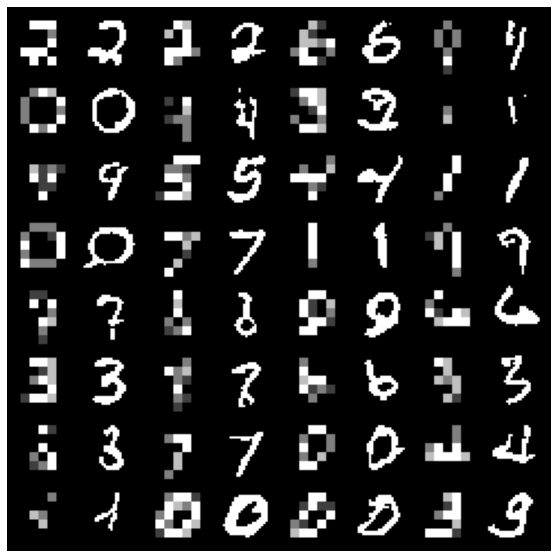

In [20]:
model = PixelCNN(device, conditional_size=(1, 7, 7), n_layers=5).to(device)
model.load_state_dict(torch.load(join('pretrained_models', 'pixelcnn_image', 'checkpoints', 'epoch9_state_dict')))

_, test_loader = load_data()
x = next(iter(test_loader))[0][:32]
cond = F.interpolate(x, scale_factor=0.25, mode='bilinear').to(device)
samples = model.sample(32, cond=cond)
cond = F.interpolate(cond, scale_factor=4).cpu()
images = torch.stack((cond, samples), dim=1)
images = images.view(-1, *images.shape[2:])
visualize_batch(images, nrow=8, figsize=(10, 10))

# Reference


- [1] "Pixel Recursive Super Resolution", Ryan Dahl, Mohammad Norouzi, Jonathon Shlens. 
[https://arxiv.org/pdf/1702.00783.pdf](https://arxiv.org/pdf/1702.00783.pdf)

- [2] "PixelCNN", Brian Keng. [http://bjlkeng.github.io/posts/pixelcnn/](http://bjlkeng.github.io/posts/pixelcnn/)

- [3] "PixelCNN", Sergei Turukin. [http://sergeiturukin.com/2017/02/22/pixelcnn.html](http://sergeiturukin.com/2017/02/22/pixelcnn.html)

- [4] Source code github. [Berkeley RLL
](https://github.com/rll)

- [5] "Deep Residual Learning for Image Recognition". Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. http://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf